In [1]:
import numpy as np
import cv2
import glob
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
IsCameraCalibration = False
IsUndistorted = False

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [5]:
def camera_calibrate(x_,y_,images_):
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((x_*y_,z), np.float32)
    objp[:,:2] = np.mgrid[0:x_, 0:y_].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images_): 
        img_ = cv2.imread(fname)
        ret,corners = get_chessboard_corners(img_,x_,y_)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (img_.shape[1],img_.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx,dist

def undistort_image(mtx_,dist_,img_):
    dst = cv2.undistort(img_, mtx_, dist_, None, mtx_)
    return dst

def get_chessboard_corners(img,x_,y_):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret_, corners_ = cv2.findChessboardCorners(gray, (x_,y_), None)
    return ret_,corners_

def create_transform_coordinates(corners_,img_):
    rect_dst =np.float32([[0,0],[img_.shape[1],0],[img_.shape[1],img_.shape[0]],[0, img_.shape[0]]])
    rect_src = np.float32([[corners_[0][0][0],corners_[0][0][1]],[corners_[x-1][0][0],corners_[x-1][0][1]],[corners_[-1][0][0],corners_[-1][0][1]],[corners_[-x][0][0],corners_[-x][0][1]]])
    return rect_src,rect_dst

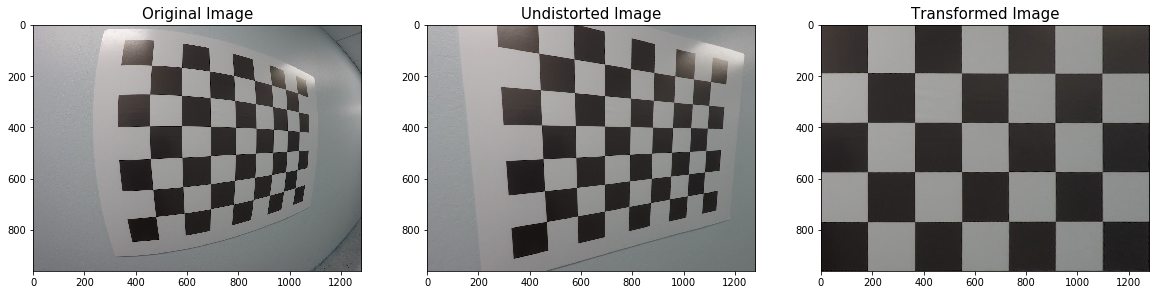

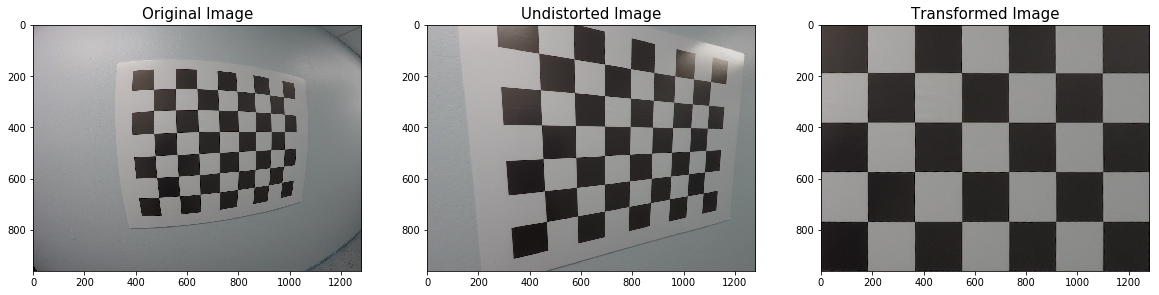

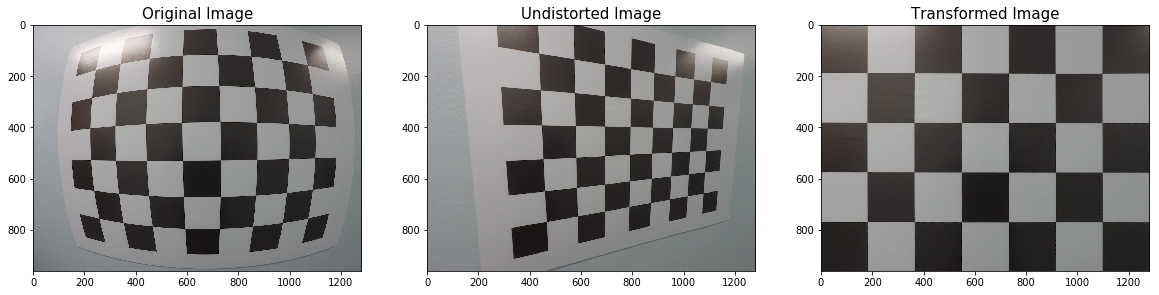

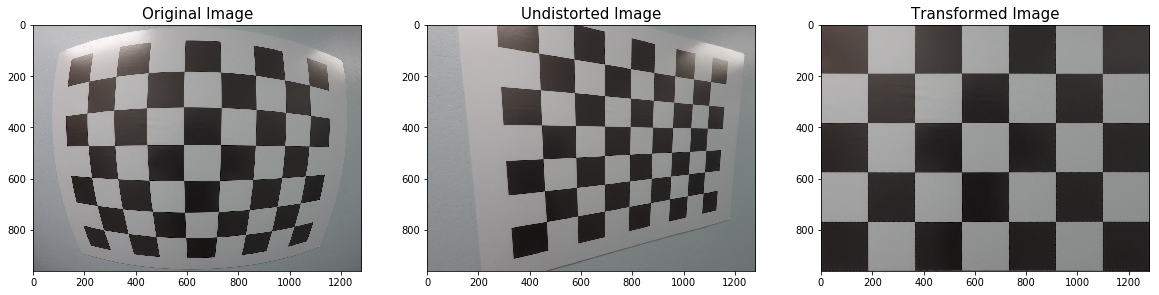

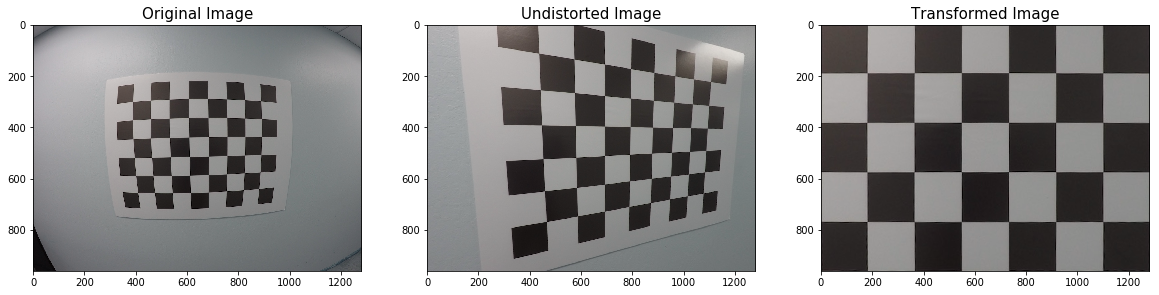

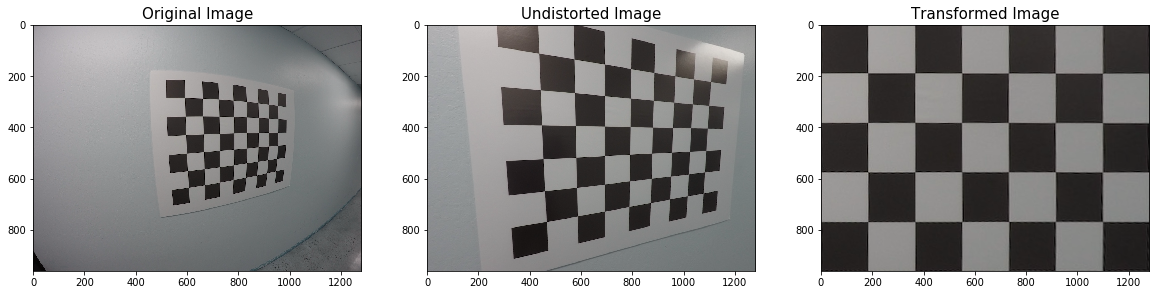

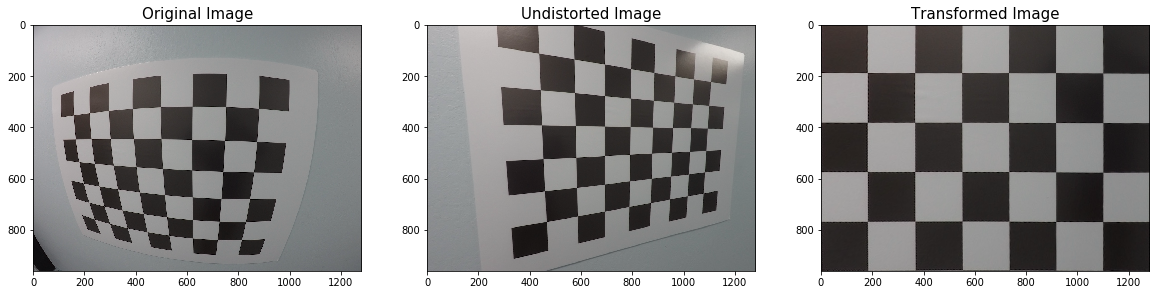

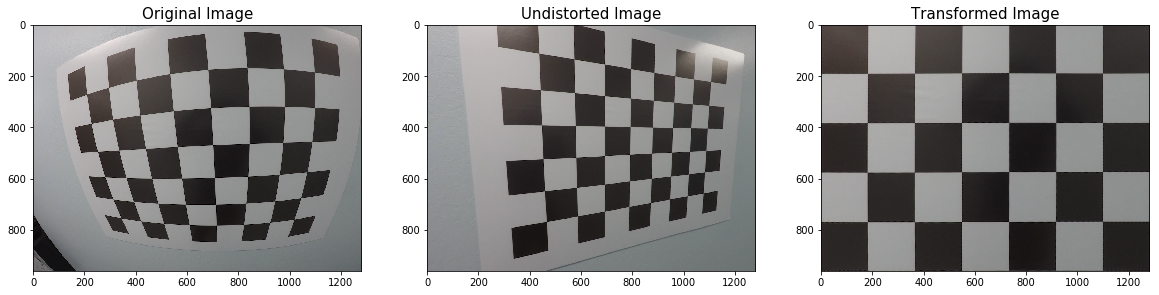

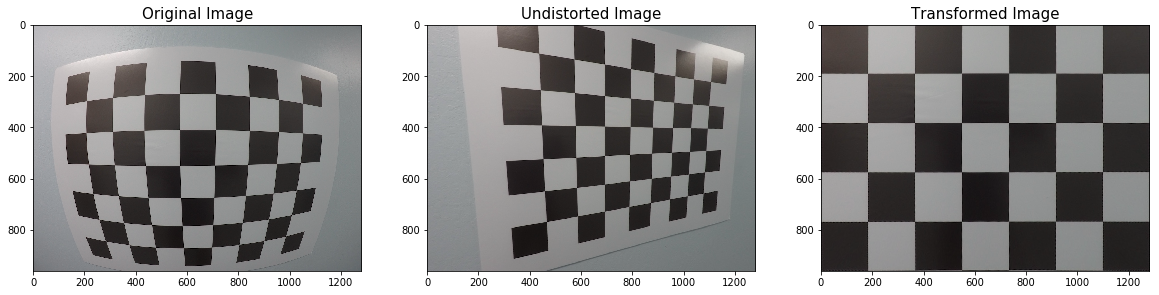

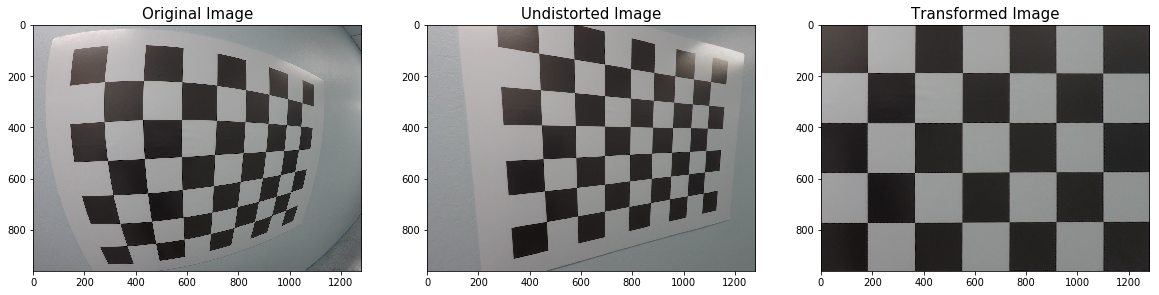

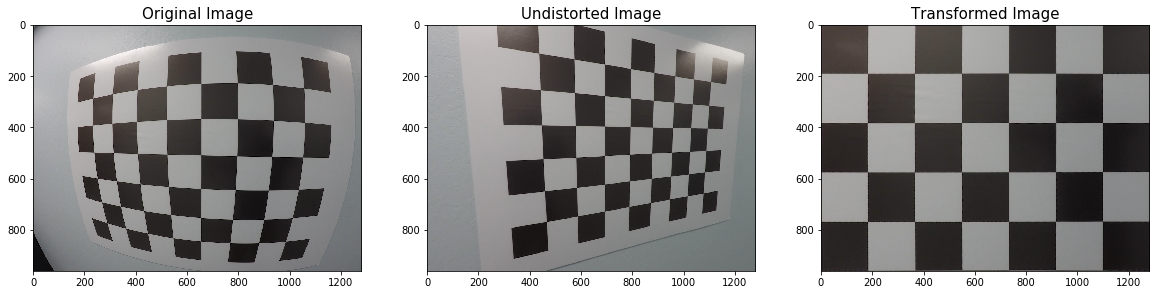

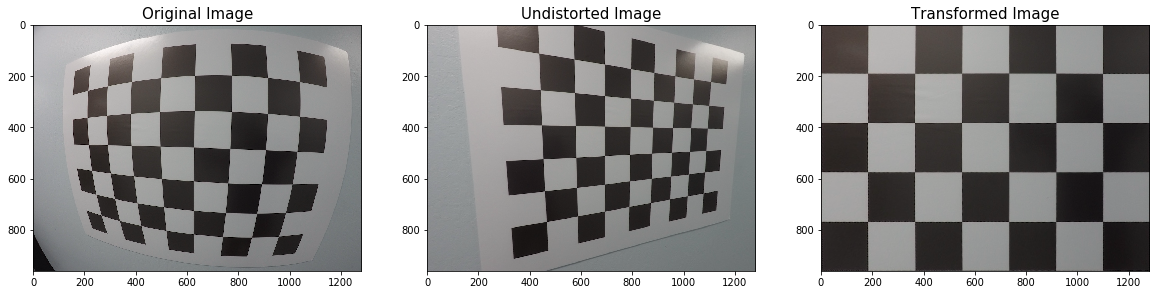

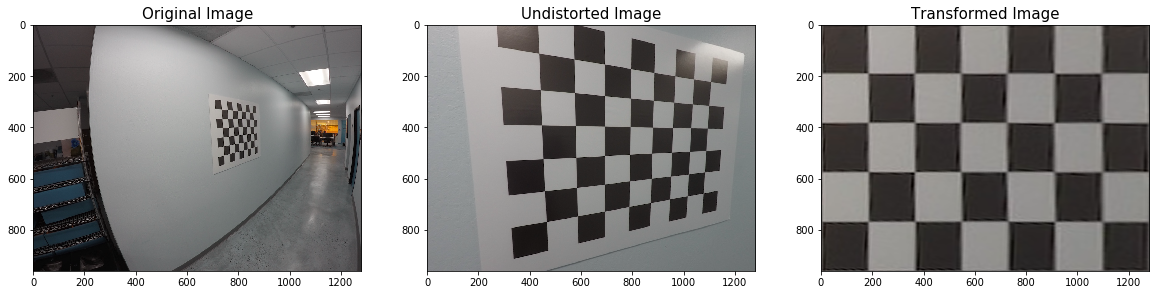

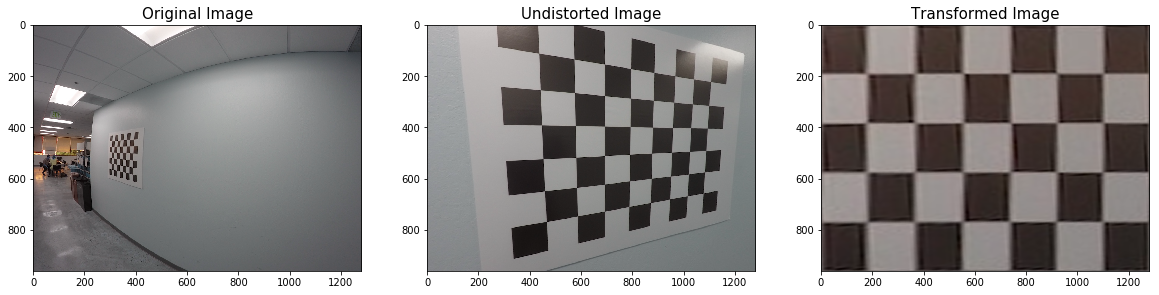

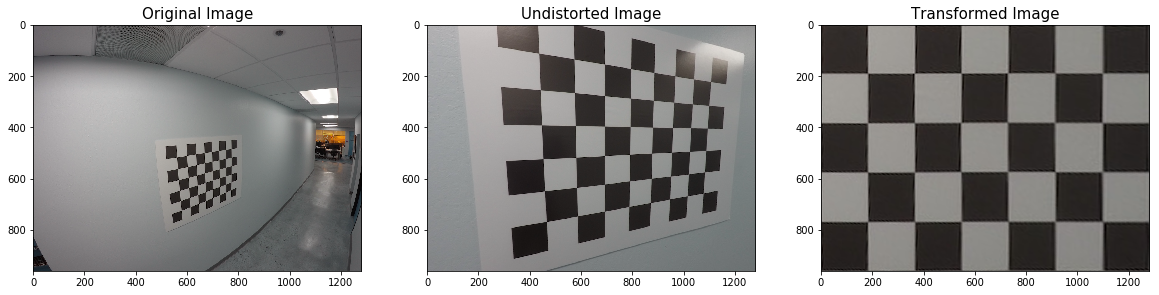

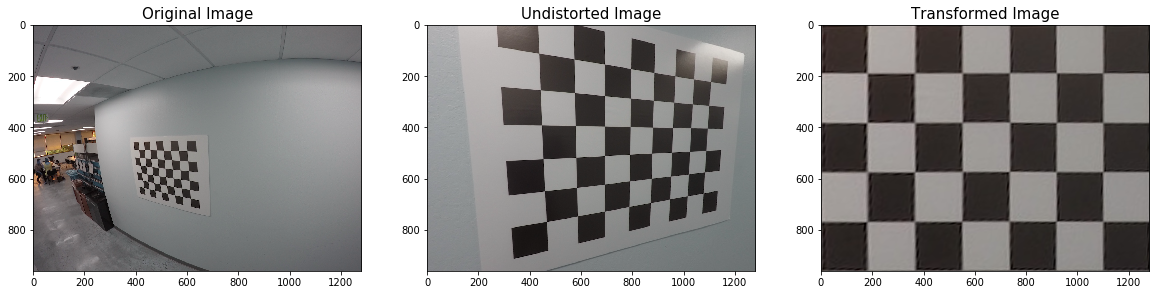

In [9]:
x=8
y=6
z=3
image_series = './calibration_wide/GOPR00*'
images = glob.glob(image_series)
mtx,dist = camera_calibrate(x,y,images)
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    fname_ = fname.split("/")[-1]
    undist = undistort_image(mtx,dist,img)
    cv2.imwrite('./Undistorted/'+fname_, undist)
    ret,corners = get_chessboard_corners(undist,x,y)
    
    if ret:
        src_,dst_ = create_transform_coordinates(corners,undist)
        M = cv2.getPerspectiveTransform(src_, dst_)
        warped = cv2.warpPerspective(undist, M, (undist.shape[1],undist.shape[0]), flags=cv2.INTER_CUBIC)
        cv2.imwrite('./Transformed/'+fname_,warped)
        f = plt.figure(figsize=(20,10))
        ax1 = f.add_subplot(1, 3, 1)
        ax1.set_title('Original Image', fontsize=15)
        ax1.imshow(img)
        ax2 = f.add_subplot(1, 3, 2)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=15)
        ax3 = f.add_subplot(1, 3, 3)
        ax3.imshow(warped)
        ax3.set_title('Transformed Image', fontsize=15)
        plt.show()
        IsUndistorted = True